# 15 Plot Top of Soil Moisture #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import pandas as pd
import xarray as xr
import numpy as np
from dask.distributed import Client
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm, CenteredNorm
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import utils, load_data

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load Data ##

In [3]:
data = load_data.load_mrsos()

In [4]:
for model, ds_dict in data.items():
    data[model]['1pctCO2-cdr'] = ds_dict['1pctCO2-cdr'].isel(time=slice(None,12*200))

In [5]:
gwl_years = load_data.load_gwl_years()

## Concatenate and separate into GWL periods ##

In [6]:
concat = {}
for model in models:
    print(model)
    ds_up = data[model]['1pctCO2']
    ds_down = data[model]['1pctCO2-cdr']
    concat[model] = utils.concat_branches(
        ds_up,
        ds_down
    )

ACCESS-ESM1-5
CanESM5
CESM2
CNRM-ESM2-1
GFDL-ESM4
MIROC-ES2L
NorESM2-LM
UKESM1-0-LL


In [7]:
gwl_periods = {}
for model, ds in concat.items():
    print(model)
    gwl_periods[model] = utils.extract_gwl_period(
        ds,
        gwl_years[model],
        21,
        time_dim='time'
    ) 

ACCESS-ESM1-5
CanESM5
CESM2
CNRM-ESM2-1
GFDL-ESM4
MIROC-ES2L
NorESM2-LM
UKESM1-0-LL


In [8]:
slices_15 = {}
gwl=1.5
for model, ds in gwl_periods.items():
    slices_15[model] = utils.compare_gwl_means(ds.sel(gwl=gwl))
differences_15 = {model: 100*(slices_15[model]['difference']/slices_15[model]['ramp_down']) for model in gwl_periods.keys()}

## Plot differences at 1.5ºC ##

In [9]:
def plot_gwl_diff(to_plot,levels):

    cmap = plt.cm.RdYlBu_r.copy()
    # cmap.set_extremes(under='midnightblue',over='maroon')
          


    fig, axes = plt.subplots(2,4, subplot_kw={"projection":ccrs.Robinson()},
                         figsize=(17,6),
                         sharey=True,)

    cbar_kwargs = {"fraction": 0.02, "aspect": 20,
                    "label":"Soil Moisture Change",'orientation':'vertical',
                    'location':'right','pad':0.01,
                  'anchor':(0.5,-4), 'extend':'both'
                  }
 
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    for (model, da), ax in zip(to_plot.items(), axes.flat):
        im = ax.imshow(to_plot[model],
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       origin='lower',
                       extent=(0,360,-90,90),
                       norm=norm
                      )
        ax.set_title(model,fontsize=16)
        ax.coastlines()

    cbar_ax = fig.add_axes([1.01,0.05,0.01,0.8])
    cbar = fig.colorbar(im,
                        cax=cbar_ax,
                        **cbar_kwargs
                       )
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label("Relative Soil Moisture Difference (%)", fontsize=16)
    fig.suptitle(f"Top soil moisture difference ramp-down - ramp-up at 1.5°C GWL",
                 fontsize=25,
                 y=1.0
                )
    fig.tight_layout()
    plt.show()

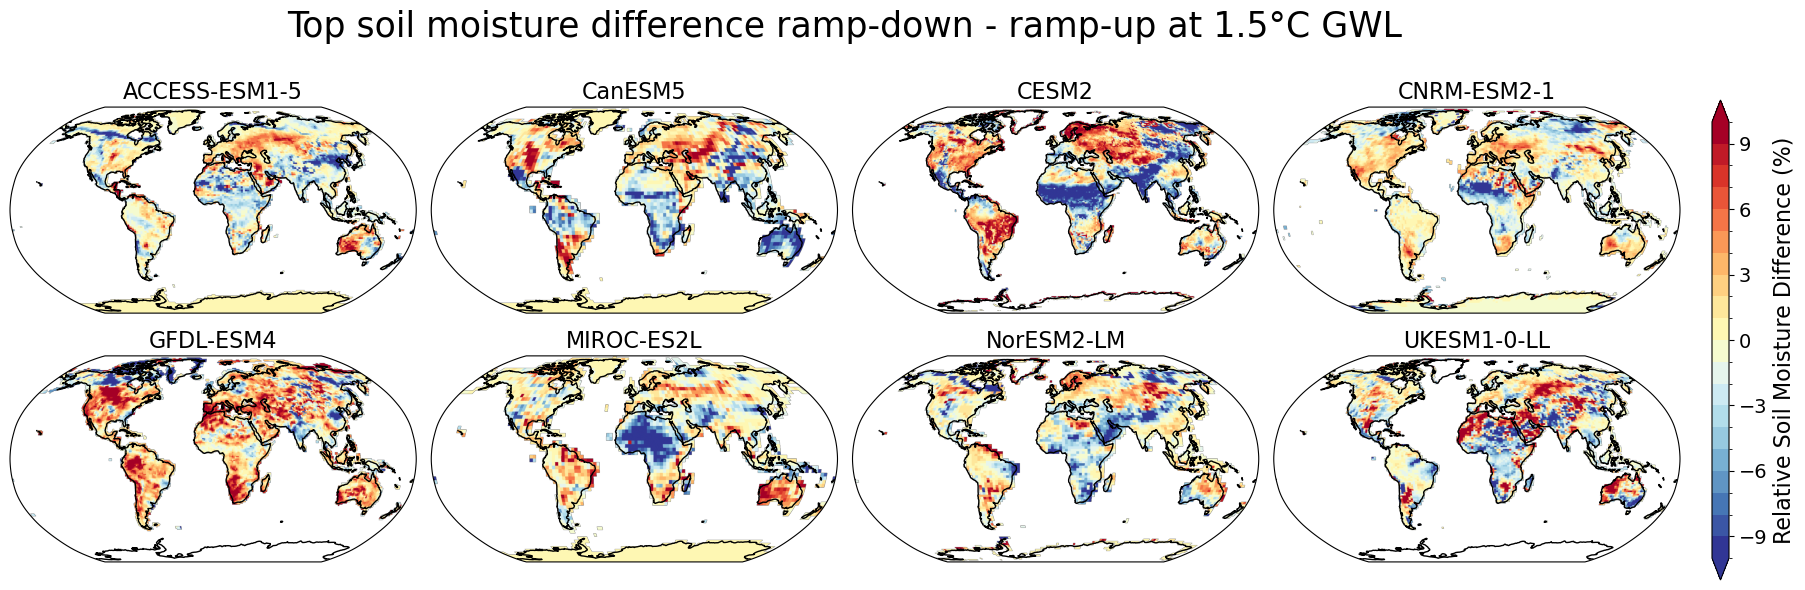

In [10]:
plot_gwl_diff(
    differences_15,
    np.linspace(-10,10,21)
)